# Neural Network - Feature Perturbation Analysis

Various problems in industry today relies on deep learning solutions ranging from fraud analytics to computer vision and speech recognition. A common question often of interest is the relation between the initial input and the final output. More specifically, what changes in initial input can alter the final result? While there are several approaches to this, here I present a mathematical approach using perturbation analysis for deep learning.
I consider a simple binary classifier with feed forward network and ReLU activations functions but the approach is generalizable to any neural network. This approach allows us to understand the impact of individual features on the n-dimensional probability density surface and can help in better controlling and predicting the effects of each feature. As this method studies the effects of the perturbation of existing surface analytically, we can use this method on pretrained networks which can save significant amount of time. As it is purely analytical, the method is extremely fast and covergent. 

In this notebook, I will present the mathematical solution, code and a few simple examples to demonstrate the efficiency and limitations of the solution. I will start with a single feature case and extend the solution to multiple features. In separate notebooks, I will demonstrate the applications of this method to some real world cases. 



## Problem Setup - 

Let's create a dataset by randomly drawing sample points from a normal distribution i.e. $X \sim \mathcal{N}(0, 1)$. The true mean of the distribution is 0 and variance is 1. We define $\hat{y}$ as


$$ \hat{y} = \begin{cases}
       1 &\quad\text{if} \,\, X> 0 \\
       0 &\quad\text{if} \,\, X\leq 0\\ 
     \end{cases}
$$
In general the method is extendable to any number of outputs. 

## Mathematical Formulation - 

### Deep Learning Model - 
Let's start with a trained $L$ layered deep neural network with $n_l$ hidden units where $l = 1....L$. The input vector represented by $X$ has total of n features. The hidden layers use ReLU activation function while the output layer uses sigmoid function. As with a trained network, all the weights and bias terms are known. Then, for given input vector $X$, the forward propagation equations for some layer $l$ can be written as - 

$$ A^{l} = g^{l}(Z^{l})$$
where
$$ Z^{l}= W^{l} A^{l-1} + B^{l}$$

Here, $A^{l}$ represets the output vector of all nodes in layer l, $g^{l}$ is the activation function for this layer, $W^{l}$ is the weight matrix and $B^{l}$ corresponds to the bias term. For $l=1$, $A^{0} = X$ is the input vector and for $L = 1$, $n_L = 1$ and hence, $A^{l}$ will be a scalar. 


### Feature Perturbation Analysis
Let's assume that output of $X$ was $0$ and we want to find change in input features $\delta X$ which would change the output to $1$. To achieve this, let's start with perturbing input $X$ (or in our notation $A^{0}$) to $X + \delta X$ (or $A^{0} + \delta A^{0}$). Then the new output of the first layer will be given as 

\begin{align}
 \tilde{Z}^{1} &= W^{1}(A^{0} + \delta A^{0}) + B^{1} \\
 &= Z^{1} + \delta Z^{1}
\end{align} 
where $\delta Z^{1} = W^{1}\delta A^{0}$
\begin{align}
\tilde{A}^{1} &= g^{1}(\tilde{Z}^{1}) \\
&= g^{1} (Z^{1}) + \nabla_{Z^{1}} g^{1}(Z^{1}) \delta Z^{1}\\
&= g^{1} (Z^{1}) + \left(\nabla_{Z^{1}} G^{1}\right) \delta Z^{1}
\end{align}

where we introduced notation $G^{l} = g^{1}(Z^{1})$ and $\nabla_{Z^{1}} G^{1}$ is $(n_l, n_l)$ dimensional matrix with gradient of $g^{l}(Z^{l})$ with respect to $Z^{l}$, i.e.


$$\nabla_{Z^{1}} G^{1} = \left[\frac{\partial g^{l}(Z^{l}_i)}{\partial Z^{l}_j}\right]_{n_l \times n_l}$$

Here, we used Taylor Expansion in the last step. As the activation functions for hidden layers are ReLU, we can stop the Taylor expansion at first derivatives. Note that ReLU is discontinuous at $Z_i^l=0$ and hence, this method will not work accurately when $Z_i^l$ and $\tilde{Z}_i^l$ have opposite signs. Generalizing this to layer $l$, we have 

\begin{align}
 \tilde{Z}^{l}&= Z^{l} + \delta Z^{l}\\
 \tilde{A}^{l} &= g^{l} (Z^{l}) + \left(\nabla_{Z^{l}} G^{l}\right) \delta Z^{l}
\end{align}

where $\delta Z^{l} = W^{l}\delta A^{l-1}$. Combining these equations , we can obtain the following recursive relation - 
\begin{equation}
\delta Z^{l} = W^{l} \,\left(\nabla_{Z^{l-1}} G^{l-1}\right) \,\delta Z^{l-1}
\end{equation}

As the activation function for the last layer is Sigmoid, Taylor expansion will not work very efficiently and ignoring higher order derivatives would introduce errors. TO tackle this, let's adopt slightly different strategy. 
For the output $\hat{Y} = 1$ for new input $\tilde{X}$, the probability should be greater than threshold T, i.e. $\tilde{A}^{L} > T$. As $\tilde{A}^{L} = \sigma (\tilde{Z}^{L})$, we can invert this function to get $\tilde{Z}^{L}$ in terms of T. This leads to 

$$ \delta Z^{L} > \log{\left(\frac{1-T}{T} \right)} - Z^{L}$$
Using the recursive relations derived earlier, we can express $\delta Z^{L}$ in terms of $\delta X$ as 

\begin{align}
\delta Z^{L} &= W^L\; \nabla_{Z^{L-1}} G^{L-1}\; ..... W^2\; \nabla_{Z^{1}} G^{1}\; W^1 \delta X\\
&= \left(\prod_{l = 0}^{L-2} W^{L-i}\nabla_{Z^{L-i-1}} G^{L-i-1}\;\right) W^1 \delta X\\
&= P^{\,L1} \delta X
\end{align}

where $ \delta Z^{1} = W^1 \delta X$ and $P^{\,L1}$ is a $(1, N)$ matrix and refers to the coefficient of $\delta X$ in seond step. Plugging into the inequality for $\delta Z^{L}$, this yields - 
$$P^{\,L1} \delta X = \log{\left(\frac{1-T}{T} \right)} - Z^{L}  $$
or 
$$\sum_{j = 1}^{n_1}P^{\,L1}_{1j} \delta X_j = \log{\left(\frac{1-T}{T} \right)} - Z^{L} $$



### Single Feature Perturbation - 
If we perturb a single feature $x_i$, then $\delta x_i$ can be accurately predicted from above equation. 

### Multiple Feature Perturbation - 
If we perturb multiple features s.t. more than 1 element of $\delta X$ is non-zero, then we require additional system of equations to determine $\delta X$ correctly. For this, we will minimize the distance of the features from its decision boundary. If we consider N dimensional feature space, where decision boundary segreagates the clusters of point with 0 or 1 class output, then in order to change the output class, one needs to cross the decision bounary. To achieve this in optimal way, we can find the closest point on the decision boundary w.r.t the given point by minimizing this distance. Then, the required change in each feature $\delta X_i$ will just be the projection of this distance on corresponding feature axis. Let's now see how this can be done -

Let's assume $\delta X$ represents the vector containing smallest change required in each element to change the final output. By construction, the distance of $X$ from the decision boundary will be $ \sqrt{(\delta X)^T(\delta X)}$. However, $\delta X$ is also constrained by above equation. Thus we have to minimize a function with given constraint which can be achieved with Lagrange Multiplier method. We start with following function - 


$$ F(\delta X, \lambda) := \delta X^T \delta X + \lambda \left[P^{\,L1}\,\delta X - \left(\log{\left(\frac{1-T}{T} \right)} - Z^{L}\right)\right] $$

And following Lagrange's method, we set the derivatives $dF/d\lambda = 0$, $dF/dX_i = 0$. Solving these equations yield - 


$$ \delta X = \frac{P^{L1}}{\sum_{i=1}^N (P^{L1}_i)^2} \left(\log{\left(\frac{1-T}{T} \right)} - Z^{L}\right)$$

As a check, we see that above equation recovers the expected result for single feature perturbation. 


### Things Which needs to be fixed - 
1. Vanishing determinant problem - if determinant goes to zero, this mthod fails
2. Varying delta x - For points near the boundary, delta x is estimated correctly, but for points further away, delta x is off by an order of magnitude. This is related with discontinuity of sigmoid function which can be seen by varying n value. At present we tackle this with iterative procedure, but a better approach is required. 
3. Here we have assumed the ideal case when neural net accuracy is almost 100%. What needs to be checked is how things change for systems with lower accuracies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import datetime


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings('ignore')


## Single Feature Perturbation

# Test Case

Let's apply this method to a test case in the following steps. 
* **Sample Data** - Generate a random sample of 10000 points from a normal distribution. 
* **Neural network** - Train a neural network classifier with multiple layers over these points. Here, I will use MPL Classifier from SKLearn with (2,3,1) layers for simplicity. SKLearn defaults threshold to 0.5 and hence, we choose the default case though the solution is generalizable to any case. 
* Choose a test dataset and compute the training and test scores. 
* Compute $\delta x$ for a few failed case and check the true and predicted value of the new input, $\tilde{x}$ 

Note that, even with 10000 points, our mean and variance differ slightly from 0 and 1. As a result, according to neural network, our decision boundary will not be $x>\mu_p$ where $\mu_p = 0$ is the population mean, but $x>\mu_s $ where $\mu_s$ is the sample mean.

In [2]:
#Change these parameters - 

hl_sizes = (3,2) #Hidden Layers Sizes
verbose=True  #Set this to true to get additional information about weights and biases. 
boundary = 0
#Create the dataset
np.random.seed(123)

Data = np.random.randn(9000)

#Data = np.arange(-100, 100, 0.01) #
#Data = Data+ np.random.rand(np.size(Data))

import random
random.shuffle(Data)

Labels = (Data>boundary)
print(np.size(Data))

Data = np.reshape(Data,(len(Data),1))

#Create training and Test datasets
X_train, X_test, y_train, y_test = train_test_split( Data, Labels, test_size=0.1, random_state=42)

#Check if mean and variance match with normal distribution
print("Mean of sample distribution = %g"%np.mean(X_train))
print("Variance of sample distribution = %g"%np.var(X_train))

#Standardize the data 
scaler = StandardScaler()
X_train_norm =  scaler.fit_transform(X_train)
X_test_norm =  scaler.transform(X_test)

9000
Mean of sample distribution = 0.0116128
Variance of sample distribution = 0.995764


In [3]:
# SKLearn
nn = MLPClassifier(alpha=1e-3, hidden_layer_sizes=hl_sizes, solver='adam', max_iter=1000, activation='relu')  
nn.fit(X_train_norm,y_train)
print("Training score - {:>1.3g} ".format(nn.score(X_train_norm,y_train)))
print("Test Score = {:>1.3g}\n".format(nn.score(X_test_norm,y_test)))


if verbose:
    print("Weights - \n Layer 1",nn.coefs_[0], '\n Layer 2', nn.coefs_[1], '\n Layer 3', nn.coefs_[2])
    print("Bias - \n Layer 1", nn.intercepts_[0], '\n Layer 2:',nn.intercepts_[1], '\n Layer 3',nn.intercepts_[2],'\n')

weight_matrix = nn.coefs_
bias = nn.intercepts_




Training score - 1 
Test Score = 1

Weights - 
 Layer 1 [[-2.79233761  6.89089534  6.51439819]] 
 Layer 2 [[ 1.92354366e-104  2.93620059e+000]
 [-3.39069959e-002 -4.51509665e+000]
 [ 7.14101194e-002 -3.51997955e+000]] 
 Layer 3 [[-0.00332347]
 [-3.32191159]]
Bias - 
 Layer 1 [0.77834677 0.37393725 0.31818499] 
 Layer 2: [-0.97270862  1.30859193] 
 Layer 3 [5.20402224] 



In [4]:
def compute_Zl(input_array, weight_matrix, bias):
    '''Compute the linear output of all the nodes in a layer before applyig the activation function
    
    Parameters:
    input_array (numpy matrix) - input vector (training data/output of previous layer)
    weight matrix (numpy matrix) - Weight matrix of trained classifier for that layer
    bias (numpy array/matrix) - bias vector for that layer
    '''
    weight = weight_matrix.T
    bias = np.reshape(bias, (np.shape(weight)[0], 1))
    Z_l = np.matmul(weight, input_array) + bias
    
    return Z_l

            
def Relu(Zi):
    return Zi * (Zi > 0)

def ModifiedRelu(Zi,n):
    
    Zi_shape = np.shape(Zi)
    Zi_flatten = np.concatenate(Zi)
    g = np.zeros(np.size(Zi_flatten))
    g[Zi_flatten>0] = Zi_flatten[Zi_flatten>0] + np.log(1 + np.exp(-n*Zi_flatten[Zi_flatten>0]))/n
    g[Zi_flatten<=0] = np.log(1 + np.exp(n*Zi_flatten[Zi_flatten<=0]))/n
    g = np.reshape(g, Zi_shape)
    
    return g

def ModifiedRelu_Derivative(Zi,n):
    return (1+np.exp(-n*Zi))**(-1)

def Sigmoid(Zi):
    return (1 + np.exp(-Zi))**-1

def compute_ZN(weights, intercepts, input_arr, use_modified_relu=False, n=100, verbose=0):
    '''Compute output of sigmoid layer. 
    
    Parameters:
    weight(numpy matrix) - Weights of trained classifier for all the layers
    intercepts (numpy matrix) - Bias terms of trained classifier for all layers
    input_arr (numpy matrix) - test data
    use_modified_relu (boolean) - Use modified version of relu instead of normal relu
    ''' 
    #Find total number of layers
    num_layers = np.shape(weights)[0]
    
    #Compute the output of each layer
    for layer_idx in range(num_layers):
            
        if layer_idx==0:
            A_i_prev = input_arr
        else:
            if use_modified_relu:
                A_i_prev = ModifiedRelu(Z_i,n)
            else:
                A_i_prev = Relu(Z_i)
                
        intercept = intercepts[layer_idx]
        Z_i = compute_Zl(A_i_prev, weights[layer_idx], intercept)
    
    Z_N = Z_i
    A_N = Sigmoid(Z_i)
    
    return Z_N, A_N


def compute_DeltaZN(weights, intercepts, input_arr, feature_idx, use_modified_relu=False, n=100,verbose=False):
    '''Compute the coefficient of delta_x in delta Z^N expression
    
    Parameters:
    weight(numpy matrix) - Weights of trained classifier for all the layers
    intercepts (numpy matrix) - Bias terms of trained classifier for all layers
    input_arr (numpy matrix) - test data
    use_modified_relu (boolean) - Use modified version of relu instead of normal relu
    ''' 
    
    #Find total number of layers
    num_layers = np.shape(weights)[0]
    
    #Compute the weight product Π_{l} W_l*Grad([g_{l-1}]) in denominator of (equation 36)
    for layer_idx in range(num_layers-1):
        if layer_idx==0:
            weight_i = weights[layer_idx][feature_idx].T
            weight_i = np.reshape(weight_i,(np.size(weight_i),1))
            A_i_prev = input_arr
        else:
            weight_i = weight_product
            if use_modified_relu:
                A_i_prev = ModifiedRelu(Z_i,n)
            else:
                A_i_prev = Relu(Z_i)
                
        intercept = intercepts[layer_idx]
        Z_i = compute_Zl(A_i_prev, weights[layer_idx], intercept)

        # As dg/dz is a diagonal matrix with elements of 0 or 1, we can reduce it to a column matrix by
        # summing over all row components. Then matrix multiplication of (dg/dz)^[l] with delta_z^[l] will
        # reduce to elementwise multiplication. 
        
        if use_modified_relu:
            dg_dz_i = ModifiedRelu_Derivative(Z_i,n)
            dg_dz_i = np.reshape(dg_dz_i,(Z_i.shape[0], Z_i.shape[1]))
            
        else:
            dg_dz_i = np.reshape((Z_i>0),(Z_i.shape[0], Z_i.shape[1]))
        weight_ip1 = weights[layer_idx+1].T
        #print(dg_dz_i, dg_dz_i*weight_i)
        weight_product = np.matmul(weight_ip1, (dg_dz_i*weight_i))
        if verbose:
            print('Z[{}] = {}'.format(layer_idx, Z_i))
            print('a[{}] = {}'.format(layer_idx, Relu(Z_i)))
        
    zN = compute_Zl(Relu(Z_i), weights[-1], intercepts[-1])
    weight_product = np.asscalar(weight_product)
    if weight_product==0:
        raise ValueError('Denominator is zero')
    return weight_product, zN
    
def compute_SingleFeature_Perturbation( output_prob, threshold, weights, intercepts, input_arr, feature_idx, use_modified_relu=False, n=100, verbose=0):
    '''Compute residue delta x which needs to be added to x to change y
    
    Parameters: 
    output_prob(float) - output probability of original input
    weights (numpy matrix) - Weights of trained classifier for all the layers
    intercepts (numpy matrix) - Bias terms of trained classifier for all layers
    input_arr (numpy matrix) - test data
    feature_idx (int) - perturbed feature index
    '''
    
    orig_ZN, orig_AN = compute_ZN(weights, intercepts, input_arr, use_modified_relu=False, n=100)
    if verbose:print('Original Values: X - {}, ZN = {}, AN = {}'.format(input_arr.item(),  orig_ZN, orig_AN))
          
    if output_prob>threshold and verbose:
        print("Output probability is already greater than threshold. Hence, no changes required in x.")
        return 0.
    
    #Check if delta X is small (corresponding output probability should be close to threshold)
    elif output_prob<threshold and output_prob>threshold/10:
        
        if verbose:print("Condition: 0.1*Threshold < output_prob < threshold")
        denom , ZN = compute_DeltaZN(weights, intercepts, input_arr, feature_idx,use_modified_relu=use_modified_relu, n=n, verbose=0)
        num = -1*np.log((1.-threshold)/threshold) - ZN
        
        delta_X =  num/denom
        delta_ZN = num
        new_input = input_arr + delta_X    
        new_ZN, new_AN = compute_ZN(weights, intercepts, new_input, use_modified_relu=False, n=100)
        iterations = 0
        if verbose:print("Updated Values - ZN = {}, AN = {}".format(new_ZN, new_AN))
            
        
    elif output_prob<threshold/10:
        if verbose:print("Condition: output_prob < 0.1*threshold")
        #new_thresholds = threshold*(np.array(1e-3,1e-2,1e-1,1))
        new_input = input_arr
        counter = 0
        new_AN = output_prob
        modified_threshold = threshold
        while (new_AN+1e-5<threshold):
            
            prev_AN = new_AN
            prev_input = new_input
            T =  min(new_AN*10, threshold)
            if verbose: print('Iter = {}, Threshold = {}'.format(counter, T))
            #if verbose:print('Threshold - {}, modified_threshold = {},output_prob = {}'.format(T, modified_threshold/10**power, new_AN))
            denom , ZN = compute_DeltaZN(weights, intercepts, new_input, feature_idx,use_modified_relu=use_modified_relu, n=n, verbose=0)
            num = -1*np.log((1.-T)/T) - ZN
            new_delta_X =  num/denom
            new_input = new_input + new_delta_X
            new_ZN, new_AN = compute_ZN(weights, intercepts, new_input, use_modified_relu=use_modified_relu, n=n)
            
            if verbose:print("Iteration:{} -  Updated ZN = {}, AN = {}".format(counter+1, new_ZN, new_AN))
            
            if new_AN > threshold+1e-2 and T>output_prob:
                new_AN = prev_AN/2.
                new_input = prev_input+1e-8
                
            elif T<output_prob:
                raise ValueError('Current Method based on Taylor Expansion not working. Please try different approach.')
                
            counter+=1
    
        delta_X = new_input - input_arr
        iterations = counter
    return (delta_X, iterations)



# Computing delta x
From above results, we see that training and test scores are 1 which assures us that neural network is working at optimal performance. But note that due to shift in the mean and variance, the decision boundary may be slightly off. Let's now apply our method to a few test cases and see if points with 0 output can be flipped. In the final result, I have shown the original values of x, true and predicted output followed by $\delta x$ and modified $x$ and corresponding true and predicted output. 

**Note -** The final output prints the data after normalization by Standard Scaler and hence, to obtain the real values, you would need to apply inverse transform operation of Standard Scaler. 

X 		 Y 	 Yhat 		 δX 	 X+δX 	 	Y_new 	 Yhat_new 	 Iterations Used
----------------------------------------------------------------------------------------------------
-1.389 		False 	 0.000 		 1.376 	 -0.012547186 	 False 	 0.504 		 18

-0.191 		False 	 0.000 		 0.179 	 -0.012547186 	 False 	 0.504 		 3

-1.333 		False 	 0.000 		 1.321 	 -0.012547186 	 False 	 0.504 		 20

-0.856 		False 	 0.000 		 0.843 	 -0.012547186 	 False 	 0.504 		 13

-0.060 		False 	 0.000 		 0.047 	 -0.012547186 	 False 	 0.504 		 5

-1.595 		False 	 0.000 		 1.583 	 -0.012547186 	 False 	 0.504 		 21

-0.457 		False 	 0.000 		 0.445 	 -0.012547186 	 False 	 0.504 		 7

-0.360 		False 	 0.000 		 0.348 	 -0.012547186 	 False 	 0.504 		 5

-1.948 		False 	 0.000 		 1.935 	 -0.012547186 	 False 	 0.504 		 26



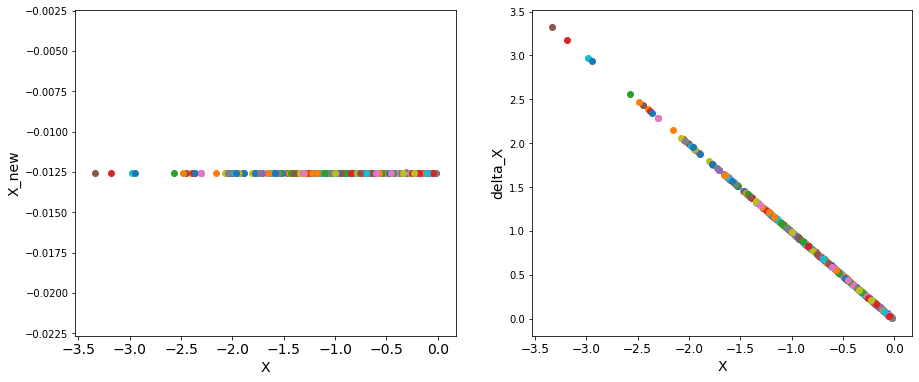

In [12]:
#SKlearn

print("X \t\t Y \t Yhat \t\t δX \t X+δX \t \tY_new \t Yhat_new \t Iterations Used")
print('-'*100)

plt.figure(figsize=(15,6))
for i, x in enumerate(np.sort(X_test_norm)):
    
    x_arr = np.reshape(x, (1, 1))
    
    yhat  = nn.predict(x_arr)
    yhat_prob = nn.predict_proba(x_arr)[0,1]
    #print(yhat_prob)
    if yhat_prob>0.5: 
        continue
    
    try:
        delta_x, iterations  = compute_SingleFeature_Perturbation(output_prob=yhat_prob, threshold=0.5, weights=weight_matrix, intercepts=bias,\
                          input_arr=x_arr, feature_idx=0, use_modified_relu=True, n=100, verbose=0)
        
    except ValueError as ve:
        #print(ve)
        continue

    x_new = x+delta_x
    if np.isinf(x_new) or x_new>1e5:
        #print('Delta x is infinite')
        continue
    
    # Apply the sample normalization to true mean to account for shift in the mean
    normalized_boundary = scaler.transform(np.reshape(boundary, (1,1)))

    # Add a small term epsilon so that final output probability is strictly greater than threshold
    epsilon = np.amin(np.abs(Data))
    yhat_new = nn.predict(x_new+epsilon)
    yhat_prob_new = nn.predict_proba(x_new+epsilon)[0,1]
    
    y_new = x_new+epsilon>normalized_boundary
    x_new_arr = np.reshape(x+delta_x, (1, 1))
    
    if i%50==0:
        print("{:>1.3f} \t\t{} \t {:>1.3f} \t\t {:>1.3f} \t {:>1.8g} \t {} \t {:>1.3f} \t\t {}\n".format(x.item(), y_test[i],  yhat_prob, delta_x.item(), x_new.item(), y_new.item(), yhat_prob_new.item(), iterations))
    plt.subplot(121)
    plt.scatter(x.item(), x_new.item())
    plt.xlabel('X', fontsize=14)
    plt.ylabel('X_new', fontsize=14)
    plt.xticks(fontsize=14 )
    
    plt.subplot(122)
    plt.scatter(x.item(), delta_x.item())
    plt.xlabel('X', fontsize=14)
    plt.ylabel('delta_X', fontsize=14)
    plt.xticks(fontsize=12 )
    
plt.show()